<a href="https://colab.research.google.com/github/manpoffc/ML-projects/blob/master/Flower_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [46]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [47]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


In [48]:
batch_size = 64
img_height = 150
img_width = 150

In [49]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [50]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [51]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


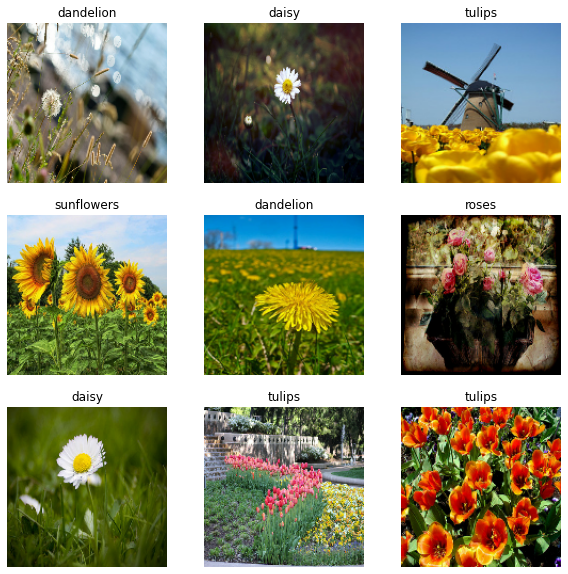

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [53]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 150, 150, 3)
(64,)


In [54]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [55]:
normalization_layer = layers.Rescaling(1./255)


In [56]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.99935937


In [57]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, (5,5), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)),
  layers.Conv2D(64, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)),
  layers.Conv2D(96, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)),
  layers.Conv2D(96, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])

In [58]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [59]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


46/46 [==============================] - 154s 3s/step - loss: 1.3112 - accuracy: 0.4087 - val_loss: 1.0908 - val_accuracy: 0.5504
Epoch 2/10
46/46 [==============================] - 151s 3s/step - loss: 1.0246 - accuracy: 0.5991 - val_loss: 0.9743 - val_accuracy: 0.6076
Epoch 3/10
46/46 [==============================] - 152s 3s/step - loss: 0.8974 - accuracy: 0.6584 - val_loss: 0.8807 - val_accuracy: 0.6499
Epoch 4/10
46/46 [==============================] - 151s 3s/step - loss: 0.8026 - accuracy: 0.6866 - val_loss: 0.9403 - val_accuracy: 0.6499
Epoch 5/10
46/46 [==============================] - 150s 3s/step - loss: 0.7293 - accuracy: 0.7159 - val_loss: 0.8633 - val_accuracy: 0.6730
Epoch 6/10
46/46 [==============================] - 151s 3s/step - loss: 0.5858 - accuracy: 0.7820 - val_loss: 0.8133 - val_accuracy: 0.7003
Epoch 7/10
46/46 [==============================] - 152s 3s/step - loss: 0.4659 - accuracy: 0.8202 - val_loss: 0.9407 - val_accuracy: 0.6826
Epoch 8/10
46/46 [======

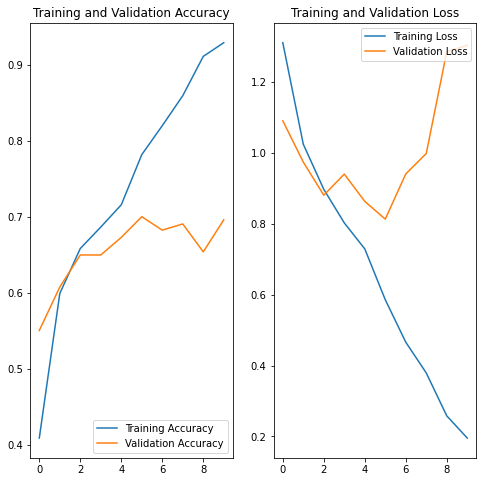

In [60]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [61]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [65]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(32, (5,5), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)),
  layers.Conv2D(64, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)),
  layers.Conv2D(96, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)),
  layers.Conv2D(96, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(num_classes,activation='softmax')
])

In [66]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
31/46 [===================>..........] - ETA: 49s - loss: 1.3614 - accuracy: 0.3841